# Data set analysis

#### Process the input data

In [1]:
#!pip install pandas
import pandas as pd
import csv

##### Changin the delimiter from ',' to ';'

In [2]:
with open('data.csv', 'r') as input_file, open('data_all.csv', 'w', newline='') as output_file:
    writer = csv.writer(output_file, delimiter=';')
    for line in input_file:
        line = line.strip()
        
        last_comma = line.rfind(',')

        if last_comma != -1:
            row = [line[:last_comma], line[last_comma + 1:]]
            
        writer.writerow(row)

##### Importing the data

In [3]:
data_all = pd.read_csv('data_all.csv', sep=';')
data_all.describe()

,ticket_description,expert_id
count,400,400
unique,40,10
top,Les permissions des rôles d'utilisateur ne fon...,expert_8
freq,16,53


##### Normalizing characters

In [4]:
import unicodedata

def normalize_chars(text):
    if isinstance(text, str):
        normalized = unicodedata.normalize('NFKD', text)
        no_diacritics = ''.join(char for char in normalized if not unicodedata.combining(char))
        return no_diacritics
    return text

data_all['ticket_description'] = data_all['ticket_description'].apply(normalize_chars)

data_all.to_csv('data_all_normalized.csv', sep=';', index=False)

##### Check for null values

In [5]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ticket_description  400 non-null    object
 1   expert_id           400 non-null    object
dtypes: object(2)
memory usage: 6.4+ KB


##### Check testity of values

In [6]:
import re

def check_row(row):
    c1 = len(row['ticket_description'].strip()) > 0
    c2 = bool(re.match(r'^expert_\d+$', row['expert_id']))
    return c1 and c2

data_all_cleaned = data_all[data_all.apply(check_row, axis=1)]

data_all = data_all_cleaned.reset_index(drop=True)

data_all.describe()

,ticket_description,expert_id
count,400,400
unique,40,10
top,Les permissions des roles d'utilisateur ne fon...,expert_8
freq,16,53


##### Change the label type from string to integer

In [7]:
for i,row in data_all.iterrows():
    data_all.at[i, 'expert_id'] = int(data_all.at[i, 'expert_id'].split('_')[1])
data_all.head()

,ticket_description,expert_id
0,Data not syncing with the cloud.,6
1,System reports inaccurate metrics.,4
2,Payment gateway timeout error.,5
3,Permissions issue for user roles.,0
4,Integration with third-party API fails.,5


##### Splitting the data into english and french parts

In [8]:
num_eng = 200

data_eng = data_all.iloc[:num_eng]
data_fr = data_all.iloc[num_eng:]

data_eng.to_csv('data_1_eng.csv', sep=';', index=False)
data_fr.to_csv('data_1_fr.csv', sep=';', index=False)

#### Analyzing the distribution

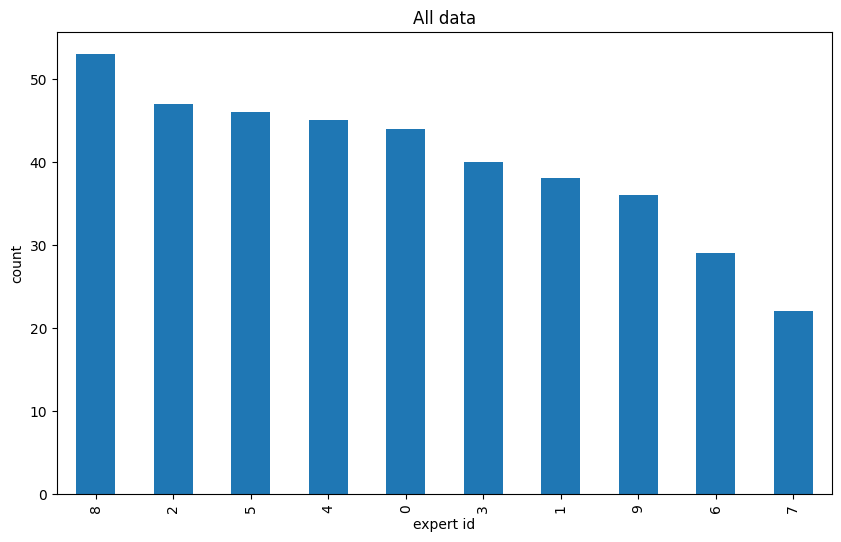

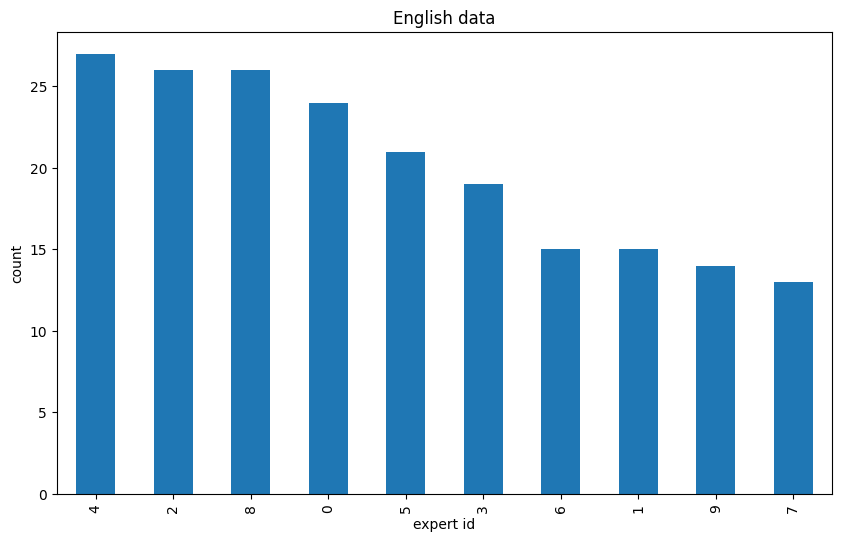

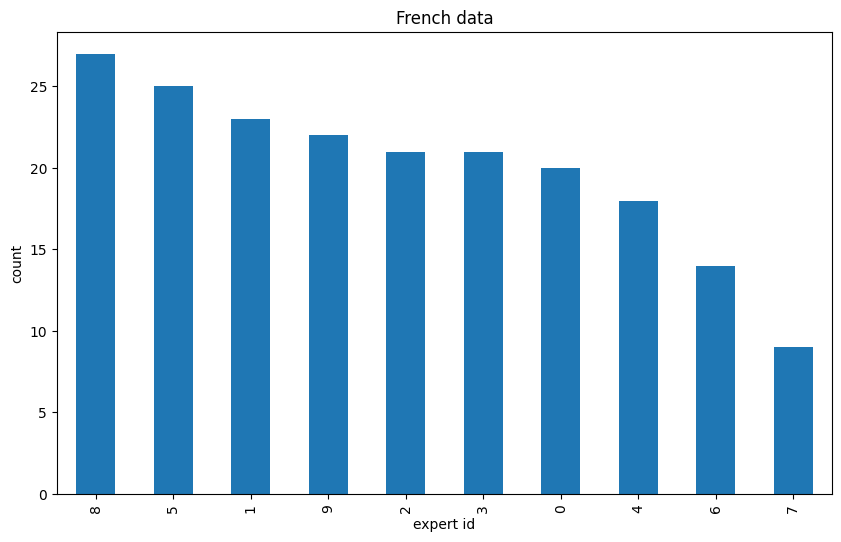

In [9]:
#!pip install matplotlib
import matplotlib.pyplot as plt

distributions = [
    (data_all['expert_id'].value_counts(), 'All data'),
    (data_eng['expert_id'].value_counts(), 'English data'),
    (data_fr['expert_id'].value_counts(), 'French data')
]

for dist, title in distributions:
    dist.plot(kind='bar', figsize=(10, 6))
    plt.title(title)
    plt.xlabel('expert id')
    plt.ylabel('count')
    plt.show()

##### Class imbalance is more present in the french data, but all together, there is no significance class imbalance

##### APPROACH 1: Removing the duplicates

In [10]:
data_1_all = data_all.drop_duplicates()
data_1_eng = data_eng.drop_duplicates()
data_1_fr = data_fr.drop_duplicates()
print(data_1_all.describe())
print(data_1_eng.describe())
print(data_1_fr.describe())

                                       ticket_description  expert_id
count                                                 250        250
unique                                                 40         10
top     Le planificateur n'execute pas les taches prog...          0
freq                                                    9         30
                         ticket_description  expert_id
count                                   124        124
unique                                   20         10
top     Application fails to save settings.          0
freq                                      8         16
                                       ticket_description  expert_id
count                                                 126        126
unique                                                 20         10
top     Le systeme genere des metriques inexactes dans...          8
freq                                                    9         16


##### APPROACH 2: Soft label encoding

In [11]:
def encode_labels(data):
    # Initialize an empty list to store the results
    result_rows = []
    
    # Number of unique classes
    num_classes = data['expert_id'].nunique()
    
    # Iterate through each ticket_description
    for ticket_description in data['ticket_description'].unique():
        # Filter rows corresponding to the current ticket_description
        filtered_rows = data[data['ticket_description'] == ticket_description]
        
        # Calculate the frequency distribution of expert_id
        frequency = filtered_rows['expert_id'].value_counts(normalize=True).reindex(range(num_classes), fill_value=0)
        expert_ids_str = ','.join(map(lambda x: f"{x:.3f}", frequency.values))
        
        # Append the result row
        result_rows.append({
            'ticket_description': ticket_description,
            'expert_ids': expert_ids_str
        })
    
    # Create a new DataFrame from the results
    return pd.DataFrame(result_rows)

data_2_all = encode_labels(data_all)
data_2_eng = encode_labels(data_eng)
data_2_fr = encode_labels(data_fr)

data_2_eng.to_csv('data_2_eng.csv', sep=';', index=False)
data_2_fr.to_csv('data_2_fr.csv', sep=';', index=False)

# Base model: Bayes classification

#### Approach 1: Split the data into train, valid and test

In [12]:
import random
import numpy as np
from sklearn.model_selection import train_test_split

def assign_train_valid_test_split(df, class_column, train_ratio=0.8, valid_ratio=0.1, test_ratio=0.1, random_seed=None):
    assert (train_ratio + valid_ratio + test_ratio) == 1.0

    # Splitting based on classes to ensure each split contains all classes
    train_data = pd.DataFrame()
    valid_data = pd.DataFrame()
    test_data = pd.DataFrame()

    for class_label, group in df.groupby(class_column):
        # Shuffle the group
        group = group.sample(frac=1, random_state=random_seed).reset_index(drop=True)

        # Calculate sizes for each split
        train_size = int(len(group) * train_ratio)
        valid_size = int(len(group) * valid_ratio)

        # Ensure at least one sample in each split
        train_size = max(train_size, 1)
        valid_size = max(valid_size, 1)
        test_size = max(len(group) - train_size - valid_size, 1)

        # Adjust sizes to fit group length
        while train_size + valid_size + test_size > len(group):
            if train_size > valid_size and train_size > test_size:
                train_size -= 1
            elif valid_size > test_size:
                valid_size -= 1
            else:
                test_size -= 1

        # Split the group
        train_split = group[:train_size]
        valid_split = group[train_size:train_size + valid_size]
        test_split = group[train_size + valid_size:]

        # Append to corresponding datasets
        train_data = pd.concat([train_data, train_split], ignore_index=True)
        valid_data = pd.concat([valid_data, valid_split], ignore_index=True)
        test_data = pd.concat([test_data, test_split], ignore_index=True)

    # Shuffle each split to randomize the order
    train_data = train_data.sample(frac=1, random_state=random_seed).reset_index(drop=True)
    valid_data = valid_data.sample(frac=1, random_state=random_seed).reset_index(drop=True)
    test_data = test_data.sample(frac=1, random_state=random_seed).reset_index(drop=True)

    # Add a 'split' column
    train_data['split'] = 'train'
    valid_data['split'] = 'valid'
    test_data['split'] = 'test'

    # Combine all splits into a single DataFrame
    final_df = pd.concat([train_data, valid_data, test_data], ignore_index=True)

    return final_df

data_all = assign_train_valid_test_split(data_all, random_seed=1, class_column='expert_id')
data_eng = assign_train_valid_test_split(data_eng, random_seed=1, class_column='expert_id')
data_fr = assign_train_valid_test_split(data_fr, random_seed=1, class_column='expert_id')

In [13]:
print(data_all.value_counts('split', normalize=True))
print(data_eng.value_counts('split', normalize=True))
print(data_fr.value_counts('split', normalize=True))

split
train    0.7900
test     0.1225
valid    0.0875
Name: proportion, dtype: float64
split
train    0.780
test     0.145
valid    0.075
Name: proportion, dtype: float64
split
train    0.780
test     0.135
valid    0.085
Name: proportion, dtype: float64


In [14]:
data_eng[data_eng['split']=='valid'].describe()

,ticket_description,expert_id,split
count,15,15,15
unique,11,10,1
top,Incorrect timezone in reports.,2,valid
freq,2,2,15


#### Approach 2: 
Since the sentances are unique, if we split the data into training and test(and valid) sets, we would have data which was not used in the training and therefore not learned on, and on the other hand we would have unique unseen data in valid and test sets which does not represent the whole data set. Becasue of this, we will use nested k fold cross validation to make sure we use all of the unique data during training and evaluating the model. 

#### Vectorizing

#### Approach 1

In [15]:
#!pip install scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [16]:
def get_tfidf_vectors_and_labels_1(df, split="train", vectorizer=None, include_valid=False):
    if vectorizer is None:
        vectorizer = TfidfVectorizer(max_features=100)
    if include_valid:
        combined_data = df[df.split.isin([split, "valid"])]
    else:
        combined_data = df[df.split == split]
    if split == "train":
        vectorizer.fit(combined_data['ticket_description'])
    vectors = vectorizer.transform(combined_data['ticket_description'])
    labels = combined_data['expert_id']#.to_numpy(dtype=int)
    return vectors.toarray(), labels.to_numpy(dtype=int), vectorizer

In [17]:
from sklearn.metrics import f1_score, classification_report

def do_tfidf_prediction(df, max_features, model='nb'):
    vectorizer = TfidfVectorizer(max_features=max_features)
    vectors_train, labels_train, vectorizer = get_tfidf_vectors_and_labels_1(df, split="train", vectorizer=vectorizer)
    vectors_test, labels_test, _ = get_tfidf_vectors_and_labels_1(df, split="test", vectorizer=vectorizer, include_valid=True)
    
    # Train the chosen classifier
    if model == 'nb':
        classifier = MultinomialNB().fit(vectors_train, labels_train)
    else:
        classifier = LogisticRegression().fit(vectors_train, labels_train)
    
    # Predictions
    predicted_train = classifier.predict(vectors_train)
    predicted_test = classifier.predict(vectors_test)
    
    # Overall F1 Scores
    f1_train = f1_score(labels_train, predicted_train, average='macro')
    f1_test = f1_score(labels_test, predicted_test, average='macro')
    
    # Per-Class F1 Scores with zero_division set to avoid warnings
    class_f1_scores = classification_report(labels_test, predicted_test, output_dict=True, zero_division=0)
    f1_per_class = [(class_name, metrics['f1-score']) for class_name, metrics in class_f1_scores.items() if isinstance(metrics, dict) and 'f1-score' in metrics]
    
    return f1_train, f1_test, f1_per_class, classifier, vectorizer


In [18]:
f1_train, f1_test, accuracy, _, _ = do_tfidf_prediction(data_all, max_features = 10)
f1_train, f1_test, accuracy

(0.12384737672814164,
 0.06161584893979259,
 [('0', 0.0),
  ('1', 0.2857142857142857),
  ('2', 0.07692307692307693),
  ('3', 0.0),
  ('4', 0.0),
  ('5', 0.0),
  ('6', 0.0),
  ('7', 0.0),
  ('8', 0.2535211267605634),
  ('9', 0.0),
  ('macro avg', 0.06161584893979259),
  ('weighted avg', 0.0695675886822768)])

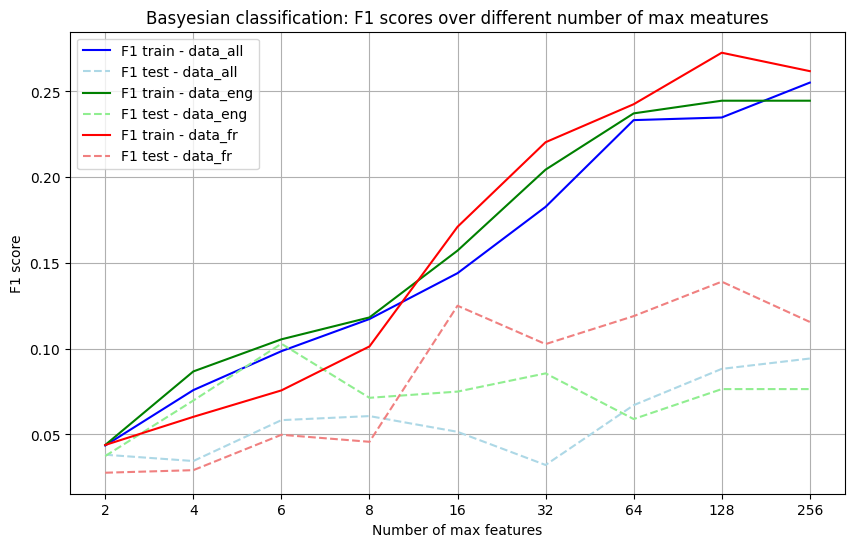

In [19]:
datasets = {
    "data_all": data_all,
    "data_eng": data_eng,
    "data_fr": data_fr
}

colors = {
    "data_all": ("blue", "lightblue"),
    "data_eng": ("green", "lightgreen"),
    "data_fr": ("red", "lightcoral")
}

max_features_list = [2, 4, 6, 8, 16, 32, 64, 128, 256]

plt.figure(figsize=(10, 6))

for dataset_name, dataset in datasets.items():
    f1_scores_train = []
    f1_scores_test = []
    for max_features in max_features_list:
        f1_train, f1_test, acc, _, _ = do_tfidf_prediction(dataset, max_features=max_features)
        f1_scores_train.append(f1_train)
        f1_scores_test.append(f1_test)
    
    plt.plot(
        np.arange(len(max_features_list)),
        f1_scores_train,
        label=f"F1 train - {dataset_name}",
        color=colors[dataset_name][0]
    )
    plt.plot(
        np.arange(len(max_features_list)),
        f1_scores_test,
        label=f"F1 test - {dataset_name}",
        color=colors[dataset_name][1],
        linestyle="dashed"
    )

plt.xticks(np.arange(len(max_features_list)), max_features_list)
plt.xlabel("Number of max features")
plt.ylabel("F1 score")
plt.title("Basyesian classification: F1 scores over different number of max meatures")
plt.legend()
plt.grid(True)

plt.show()


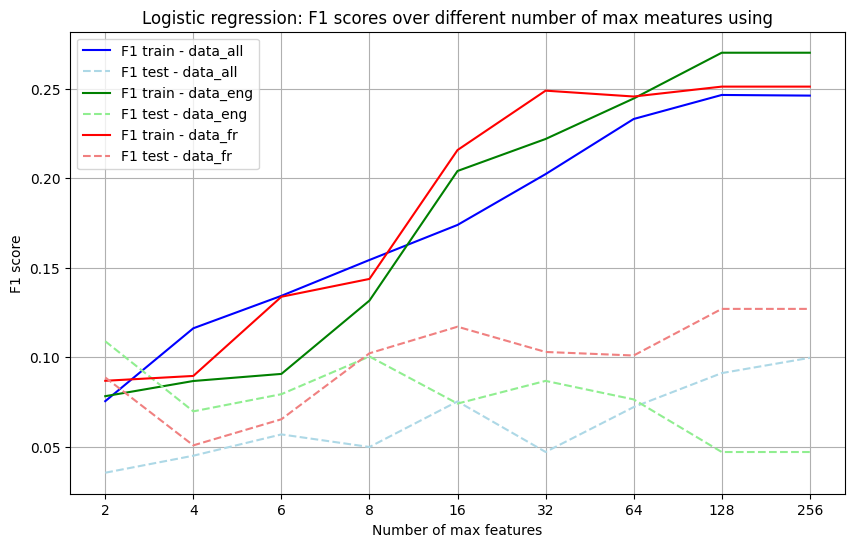

In [20]:
datasets = {
    "data_all": data_all,
    "data_eng": data_eng,
    "data_fr": data_fr
}

colors = {
    "data_all": ("blue", "lightblue"),
    "data_eng": ("green", "lightgreen"),
    "data_fr": ("red", "lightcoral")
}

max_features_list = [2, 4, 6, 8, 16, 32, 64, 128, 256]

plt.figure(figsize=(10, 6))

for dataset_name, dataset in datasets.items():
    f1_scores_train = []
    f1_scores_test = []
    for max_features in max_features_list:
        f1_train, f1_test, acc, _, _ = do_tfidf_prediction(dataset, max_features=max_features, model='logistic')
        f1_scores_train.append(f1_train)
        f1_scores_test.append(f1_test)
    
    plt.plot(
        np.arange(len(max_features_list)),
        f1_scores_train,
        label=f"F1 train - {dataset_name}",
        color=colors[dataset_name][0]
    )
    plt.plot(
        np.arange(len(max_features_list)),
        f1_scores_test,
        label=f"F1 test - {dataset_name}",
        color=colors[dataset_name][1],
        linestyle="dashed"
    )

plt.xticks(np.arange(len(max_features_list)), max_features_list)
plt.xlabel("Number of max features")
plt.ylabel("F1 score")
plt.title("Logistic regression: F1 scores over different number of max meatures using")
plt.legend()
plt.grid(True)

plt.show()


In [21]:
data_all.describe()

,ticket_description,expert_id,split
count,400,400,400
unique,40,10,3
top,Les permissions des roles d'utilisateur ne fon...,8,train
freq,16,53,316


In [22]:
f1_train, f1_test, f1_per_class, classifier, vectorizer = do_tfidf_prediction(data_all, max_features = 16)
f1_train, f1_test, f1_per_class

(0.14405420887495762,
 0.05153393085787452,
 [('0', 0.0),
  ('1', 0.18181818181818182),
  ('2', 0.08),
  ('3', 0.0),
  ('4', 0.0),
  ('5', 0.0),
  ('6', 0.0),
  ('7', 0.0),
  ('8', 0.2535211267605634),
  ('9', 0.0),
  ('macro avg', 0.05153393085787452),
  ('weighted avg', 0.060039022010852997)])

##### Inference

In [23]:
def inference_1(classifier, input_sentence, vectorizer, k=3):
    """
    Perform inference on a single input sentence using the trained classifier.

    Parameters:
    - classifier: Trained classifier (e.g., MultinomialNB, LogisticRegression).
    - input_sentence: The input sentence (string) to classify.
    - vectorizer: Trained TfidfVectorizer used for preprocessing.
    - k: Number of top predictions to return.

    Returns:
    - top_k_classes: List of top-k predicted class labels.
    - top_k_probs: List of top-k probabilities corresponding to the predicted classes.
    """
    # Vectorize the input sentence using the trained vectorizer
    input_vector = vectorizer.transform([input_sentence]).toarray()

    # Predict probabilities for each class
    if hasattr(classifier, "predict_proba"):
        probs = classifier.predict_proba(input_vector).squeeze()
    else:
        raise ValueError("The provided classifier does not support probability prediction.")
    
    # Get the top-k predictions
    top_k_indices = np.argsort(probs)[-k:][::-1]  # Indices of top-k probabilities
    top_k_classes = [f"class_{i}" for i in top_k_indices]  # Replace with actual class names if available
    top_k_probs = probs[top_k_indices]

    return top_k_classes, top_k_probs


inference_1(classifier, 'Memory limit exceeded.', vectorizer, k=3)

(['class_8', 'class_2', 'class_5'],
 array([0.13291139, 0.11708861, 0.11392405]))

#### Approach 2

In [24]:
def get_tfidf_vectors_and_labels_2(df, indices, vectorizer=None, fit_vectorizer=False):
    data_subset = df.iloc[indices]
    if fit_vectorizer:
        vectorizer.fit(data_subset['ticket_description'])
    vectors = vectorizer.transform(data_subset['ticket_description'])

    # Convert 'expert_ids' strings to 2D array of floats
    labels = np.array([
        list(map(float, label.split(','))) for label in data_subset['expert_ids']
    ])

    return vectors.toarray(), labels, vectorizer

In [25]:
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
import numpy as np

def nested_kfold_tfidf(df, max_features, model='nb', outer_splits=5, inner_splits=3):
    outer_kf = KFold(n_splits=outer_splits, shuffle=True, random_state=42)
    results = []

    for train_idx, test_idx in outer_kf.split(df):
        # Outer fold train/test split
        train_df, test_df = df.iloc[train_idx], df.iloc[test_idx]
        inner_kf = KFold(n_splits=inner_splits, shuffle=True, random_state=42)
        
        best_model = None
        best_score = float('inf')  # For hyperparameter tuning (minimize loss)
        vectorizer = TfidfVectorizer(max_features=max_features)

        for inner_train_idx, inner_val_idx in inner_kf.split(train_df):
            # Inner fold train/validation split
            train_vectors, train_labels, vectorizer = get_tfidf_vectors_and_labels_2(
                train_df, inner_train_idx, vectorizer, fit_vectorizer=True
            )
            val_vectors, val_labels, _ = get_tfidf_vectors_and_labels_2(
                train_df, inner_val_idx, vectorizer
            )

            print(f'train_vectors.shape: {train_vectors.shape}')
            print(f'train_labels.shape: {train_labels.shape}')
            print(f'val_vectors.shape: {val_vectors.shape}')
            print(f'train_labels.shape: {train_labels.shape}')
            #print(train_labels)
            #print(val_vectors)
            #print(val_labels)
            
            # Train the chosen classifier
            if model == 'nb':
                classifier = MultinomialNB().fit(train_vectors, np.argmax(train_labels, axis=1))
            else:
                classifier = LogisticRegression().fit(train_vectors, np.argmax(train_labels, axis=1))
            
            # Predict probabilities
            predicted_probs = classifier.predict_proba(val_vectors)
            # Compute log-loss
            print(f"val_labels: {val_labels}")
            print(f"predicted_probs: {predicted_probs}")
            print(f"val_labels.shape: {val_labels.shape}, predicted_probs.shape: {predicted_probs.shape}")
            score = log_loss(val_labels, predicted_probs, labels=np.arange(num_classes))
            
            # Track best model
            if score < best_score:
                best_model = classifier
                best_score = score
        
        # Evaluate the best model on the outer test set
        test_vectors, test_labels, _ = get_tfidf_vectors_and_labels_2(
            df, test_idx, vectorizer
        )
        predicted_probs = best_model.predict_proba(test_vectors)
        test_loss = log_loss(test_labels, predicted_probs)
        results.append(test_loss)
    
    # Average performance across outer folds
    final_score = np.mean(results)
    return final_score, results


In [26]:
#nested_kfold_tfidf(data_2_all, max_features = 10)

##### Conclusion: The dataset is too small to produce high quality results using traditional machine learning methods such as Naive Bayes and Logistic Regression with TF-IDF. The limited data size leads to overfitting on the training set, and poor generalization on the test set. The results are generally poor and similar, with French dataset performing the worst, with slightly better and similar results for combined and English only dataset. 

##### Even though logistic regression should generally perform better than Naive Bayes, here it is not the case. Possibly because they share the same TF-IDF features, which are sparse because the sentances are short and contain a small number of all features. This can be seen on the plot, as test perfomance lowers with the increased numbers of max features. The logistic regression would possibly achieve better performance if we had more input data.

# First model: BERT

In [27]:

x_train_all = data_all[data_all.split=='train']['ticket_description'].values
y_train_all = data_all[data_all.split=='train']['expert_id'].values
x_valid_all = data_all[data_all.split=='valid']['ticket_description'].values
y_valid_all = data_all[data_all.split=='valid']['expert_id'].values
x_test_all = data_all[data_all.split=='test']['ticket_description'].values
y_test_all = data_all[data_all.split=='test']['expert_id'].values


x_train_eng = data_eng[data_eng.split=='train']['ticket_description'].values
y_train_eng = data_eng[data_eng.split=='train']['expert_id'].values
x_valid_eng = data_eng[data_eng.split=='valid']['ticket_description'].values
y_valid_eng = data_eng[data_eng.split=='valid']['expert_id'].values
x_test_eng = data_eng[data_eng.split=='test']['ticket_description'].values
y_test_eng = data_eng[data_eng.split=='test']['expert_id'].values


In [28]:
data_all[data_all.split=='test'].describe()

,ticket_description,expert_id,split
count,49,49,49
unique,25,10,1
top,Error 404 when accessing the application.,5,test
freq,8,6,49


In [29]:
data_eng[data_eng.split=='valid'].describe()

,ticket_description,expert_id,split
count,15,15,15
unique,11,10,1
top,Incorrect timezone in reports.,2,valid
freq,2,2,15


In [30]:
#!pip install transformers
from transformers import DistilBertTokenizer

MAX_LEN = 0

tokenizer_eng = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', padding=True, truncation=True)
tokenizer_all = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased', padding=True, truncation=True)

all_data = np.concatenate((x_train_all, x_valid_all, x_test_all))

# let's check out how the tokenizer works
for i in range(len(all_data)):
    if len(tokenizer_eng(all_data[i])['input_ids']) > MAX_LEN:
        MAX_LEN = len(tokenizer_eng(all_data[i])['input_ids'])
    if i == 0:
        # tokenize sentences
        tokenizer_out = tokenizer_eng(all_data[i])
        # convert numerical tokens to alphabetical tokens
        encoded_tok = tokenizer_eng.convert_ids_to_tokens(tokenizer_out.input_ids)
        # decode tokens back to string
        decoded = tokenizer_eng.decode(tokenizer_out.input_ids)
        print(tokenizer_out)
        print('\n')
        print(encoded_tok, '\n')
        print('\n')
        print(decoded, '\n')
        print('\n')
        print('---------------- \n')

MAX_LEN = MAX_LEN * 2
MAX_LEN

C:\Users\David\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'input_ids': [101, 2543, 9628, 5991, 4646, 4026, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


['[CLS]', 'fire', '##wall', 'blocks', 'application', 'traffic', '.', '[SEP]'] 



[CLS] firewall blocks application traffic. [SEP] 



---------------- 



72

In [31]:
#!C:\Users\David\AppData\Local\Programs\Python\Python311\python.exe -m pip install ipykernel
#!C:\Users\David\AppData\Local\Programs\Python\Python311\python.exe -m ipykernel install --user --name python311 --display-name "Python 3.11 (torch)"

In [32]:
!pip show torch
!python --version
import sys
print(sys.executable)

Name: torch
Version: 2.5.1
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: C:\Users\David\AppData\Local\Programs\Python\Python311\Lib\site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: accelerate, torchaudio, torchvision
Python 3.11.0
C:\Users\David\AppData\Local\Programs\Python\Python311\python.exe


##### Creating the custom dataset

In [33]:
#!pip3 install torch torchvision torchaudio
import torch
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, item):
        # select the sentence and its class
        sentence = str(self.sentences[item])
        label = self.labels[item]
        # tokenize the sencence
        tokenizer_out = self.tokenizer(
            sentence,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        # return a dictionary with the output of the tokenizer and the label
        return  {
            'input_ids': tokenizer_out['input_ids'].flatten(),
            'attention_mask': tokenizer_out['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

train_dataset_all = MyDataset(x_train_all, y_train_all, tokenizer_all, MAX_LEN)
valid_dataset_all = MyDataset(x_valid_all, y_valid_all, tokenizer_all, MAX_LEN)
test_dataset_all = MyDataset(x_test_all, y_test_all, tokenizer_all, MAX_LEN)

train_dataset_eng = MyDataset(x_train_eng, y_train_eng, tokenizer_eng, MAX_LEN)
valid_dataset_eng = MyDataset(x_valid_eng, y_valid_eng, tokenizer_eng, MAX_LEN)
test_dataset_eng = MyDataset(x_test_eng, y_test_eng, tokenizer_eng, MAX_LEN)

In [34]:
train_dataset_all[0]

{'input_ids': tensor([  101, 16011, 33743, 47352, 19800, 26482,   119,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'label': tensor(4)}

##### Importing the model

In [35]:
from transformers import DistilBertModel

PRE_TRAINED_MODEL_NAME_ENG = 'distilbert-base-uncased'
PRE_TRAINED_MODEL_NAME_ALL = 'distilbert-base-multilingual-cased'


distil_bert_eng = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME_ENG)
distil_bert_all = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME_ALL)
print(distil_bert_eng)
print(distil_bert_all)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

##### Inspect the output shape of the model

In [36]:
train_dataset_all[0]

{'input_ids': tensor([  101, 16011, 33743, 47352, 19800, 26482,   119,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'label': tensor(4)}

In [37]:
first_sample = train_dataset_eng[0]
hidden_state = distil_bert_eng(first_sample['input_ids'].unsqueeze(0), attention_mask=first_sample['attention_mask'].unsqueeze(0))
hidden_state[0].shape

torch.Size([1, 72, 768])

##### Building the classifier

from transformers import DistilBertPreTrainedModel

FREEZE = True

class DistilBertClassifier(DistilBertPreTrainedModel):
    def __init__(self, config, num_labels, freeze=False):
        super.__init__(config)
        self.num_labels = num_labels
        self.encoder = DistilBertModel.from_pretrained(MODEL_NAME)
        if freeze:
            for param in self.encoder.parameters():
                param.requires_grad = False
        self.classifier = torch.nn.Linear(
            in_features = config.dim,
            out_features = self.num_labels,
            bias=True
        )
        self.dropout = torch.nn.Dropout(p=-0.1)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
    ):
        encoder_output = self.encoder(
            input_ids = input_ids,
            attention_mask = attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            labels=labels,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
        )

        hidden_state = encoder_output[0]
        pooled_output = hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + encoder_output[1:]

        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits, labels)
            outputs = (loss,) + outputs
            
        outputs = (loss,) + outputs
    
    return outputs
    
classes = data_all.expert_id.unique()

model = DistilBertClassifier(
    config=distil_bert.configm,
    num_labels = len(classes),
    freeze = FREEZE
)

In [38]:
from transformers import DistilBertPreTrainedModel, DistilBertConfig


#PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased'
FREEZE_PRETRAINED_MODEL = True

class DistilBertForSentimentClassification(DistilBertPreTrainedModel):
    def __init__(self, pretrained_model_name, config, num_labels, freeze_encoder=False):
        # instantiate the parent class DistilBertPreTrainedModel
        super().__init__(config)
        # instantiate num. of classes
        self.num_labels = num_labels
        # instantiate and load a pretrained DistilBERT model as encoder
        self.encoder = DistilBertModel.from_pretrained(pretrained_model_name)
        # [Q1] freeze the encoder parameters if required
        if freeze_encoder:
          for param in self.encoder.parameters():
              param.requires_grad = False
        # the classifier: a feed-forward layer attached to the encoder's head
        self.classifier = torch.nn.Linear(
            in_features=config.dim, out_features=self.num_labels, bias=True)
        # instantiate a dropout function for the classifier's input
        self.dropout = torch.nn.Dropout(p=0.1)


    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
    ):
        # encode a batch of sequences with DistilBERT
        encoder_output = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
        )
        # extract the hidden representations from the encoder output
        hidden_state = encoder_output[0]  # (bs, seq_len, dim)
        # only select the encoding corresponding to the first token
        # of each sequence in the batch [Q2]
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        # apply dropout
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        # feed into the classifier
        logits = self.classifier(pooled_output)  # (bs, dim)

        outputs = (logits,) + encoder_output[1:]

        if labels is not None:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

classes = data_all.expert_id.unique().tolist()

# instantiate model
model_eng_only = DistilBertForSentimentClassification(
    pretrained_model_name=PRE_TRAINED_MODEL_NAME_ENG,
    config=distil_bert_eng.config,
    num_labels=len(classes),
    freeze_encoder = FREEZE_PRETRAINED_MODEL
    )

"""model_eng_all = DistilBertForSentimentClassification(
    pretrained_model_name=PRE_TRAINED_MODEL_NAME_ENG,
    config=distil_bert_eng.config,
    num_labels=len(classes),
    freeze_encoder = FREEZE_PRETRAINED_MODEL
)"""

model_all = DistilBertForSentimentClassification(
    pretrained_model_name=PRE_TRAINED_MODEL_NAME_ALL,
    config=distil_bert_all.config,
    num_labels=len(classes),
    freeze_encoder = FREEZE_PRETRAINED_MODEL
)

"""
# print info about model's parameters
total_params = sum(p.numel() for p in model.parameters())
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
trainable_params = sum([np.prod(p.size()) for p in model_parameters])
print('model total params: ', total_params)
print('model trainable params: ', trainable_params)
print('\n', model)
"""

"\n# print info about model's parameters\ntotal_params = sum(p.numel() for p in model.parameters())\nmodel_parameters = filter(lambda p: p.requires_grad, model.parameters())\ntrainable_params = sum([np.prod(p.size()) for p in model_parameters])\nprint('model total params: ', total_params)\nprint('model trainable params: ', trainable_params)\nprint('\n', model)\n"

##### Train the model

In [39]:
if torch.cuda.is_available():
    print('GPU will be used.')
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    print('CPU will be used.')

CPU will be used.


In [40]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1.tolist(),
        'precision': precision.tolist(),
        'recall': recall.tolist()
    }

training_args = TrainingArguments(
    output_dir='./results',
    logging_dir='./logs',
    logging_first_step=True,
    logging_steps=20,
    num_train_epochs=16,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    learning_rate=5e-6,
    weight_decay=0.01
)

trainer_eng_only = Trainer(
    model=model_eng_only,
    args=training_args,
    train_dataset=train_dataset_eng,
    eval_dataset=valid_dataset_eng,
    compute_metrics=compute_metrics
)
"""
trainer_eng_all = Trainer(
    model=model_eng_all,
    args=training_args,
    train_dataset=train_dataset_all,
    eval_dataset=valid_dataset_all,
    compute_metrics=compute_metrics
)
"""
trainer_all = Trainer(
    model=model_all,
    args=training_args,
    train_dataset=train_dataset_all,
    eval_dataset=valid_dataset_all,
    compute_metrics=compute_metrics
)

In [41]:
trainer_eng_only.train()
#trainer_eng_all.train()
trainer_all.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.363200,2.333450,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,2.363600,2.331743,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,2.343900,2.330141,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,2.332200,2.328770,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
5,2.366200,2.327674,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
6,2.347300,2.326565,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
7,2.361200,2.325485,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
8,2.336200,2.324651,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,2.357700,2.323900,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
10,2.357700,2.323189,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.322600,2.301170,0.142857,"[0.3, 0.18181818181818182, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.1875, 0.10526315789473684, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.75, 0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,2.334000,2.299654,0.142857,"[0.2727272727272727, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.16666666666666666, 0.11764705882352941, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.75, 0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,2.334700,2.298232,0.142857,"[0.2727272727272727, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.16666666666666666, 0.11764705882352941, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.75, 0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,2.290200,2.296758,0.142857,"[0.2608695652173913, 0.21052631578947367, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.15789473684210525, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.75, 0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
5,2.310500,2.295690,0.142857,"[0.2608695652173913, 0.21052631578947367, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.15789473684210525, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.75, 0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
6,2.284500,2.294556,0.142857,"[0.3076923076923077, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.18181818181818182, 0.07692307692307693, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
7,2.332600,2.293587,0.142857,"[0.2857142857142857, 0.14285714285714285, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.16666666666666666, 0.09090909090909091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
8,2.322100,2.292943,0.142857,"[0.2857142857142857, 0.14285714285714285, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.16666666666666666, 0.09090909090909091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,2.298100,2.292170,0.142857,"[0.26666666666666666, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.15384615384615385, 0.1111111111111111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
10,2.287100,2.291555,0.142857,"[0.26666666666666666, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.15384615384615385, 0.1111111111111111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


TrainOutput(global_step=640, training_loss=2.3105590995401144, metrics={'train_runtime': 115.4488, 'train_samples_per_second': 43.794, 'train_steps_per_second': 5.544, 'total_flos': 92907791271936.0, 'train_loss': 2.3105590995401144, 'epoch': 16.0})

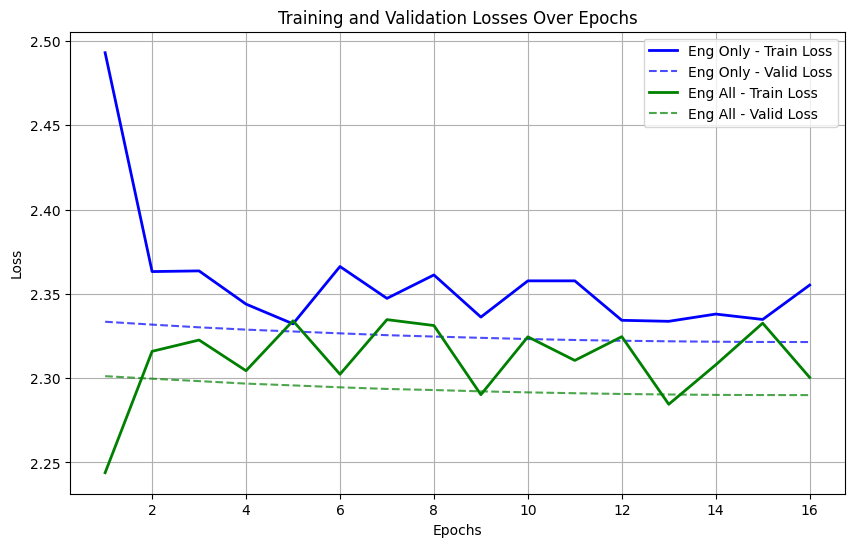

In [42]:
def plot_losses(trainers, labels, colors):
    """
    Plots training and validation losses over epochs for multiple trainers.

    Args:
        trainers (list): List of Trainer objects.
        labels (list): List of labels for each trainer.
        colors (list): List of base colors for each model.
    """
    plt.figure(figsize=(10, 6))

    for trainer, label, color in zip(trainers, labels, colors):
        # Extract log history
        log_history = trainer.state.log_history

        # Filter epoch-level training losses (ensure 'epoch' key exists)
        train_losses = [
            entry['loss'] for entry in log_history 
            if 'loss' in entry and 'epoch' in entry
        ]
        # Extract validation losses (eval_loss at the end of each epoch)
        eval_losses = [
            entry['eval_loss'] for entry in log_history 
            if 'eval_loss' in entry
        ]

        # Ensure lengths match
        min_length = min(len(train_losses), len(eval_losses))
        train_losses = train_losses[:min_length]
        eval_losses = eval_losses[:min_length]

        # Define x-axis for epochs
        epochs = range(1, min_length + 1)

        # Plot training and validation losses
        plt.plot(epochs, train_losses, label=f"{label} - Train Loss", color=color, linewidth=2)
        plt.plot(epochs, eval_losses, label=f"{label} - Valid Loss", color=color, linestyle='dashed', alpha=0.7)

    # Add labels, legend, and grid
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Losses Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()




    
# Plot losses
plot_losses(
    trainers=[trainer_eng_only, trainer_all],#trainer_eng_all, trainer_all],
    labels=["Eng Only", "Eng All", "All"],
    colors=["blue", "green", "red"]  # Base colors for each model
)

the output: there is 160 samples, and batchsize of 8, so 160/8=20 batches per epoch. and there are 16 epochs, so 20*16=320. the logging is done in step of 50, which is defined in the trainer initialization

In [43]:
test_results_eng_only = trainer_eng_only.predict(test_dataset=test_dataset_eng)
#test_results_eng_all = trainer_eng_all.predict(test_dataset=test_dataset_all)
test_results_all = trainer_all.predict(test_dataset=test_dataset_all)

In [44]:
len(test_results_eng_only.metrics['test_f1'])

10

In [45]:
data_eng[data_eng['split']=='test'].head(20)

,ticket_description,expert_id,split
171,Unable to connect to the database.,4,test
172,Error 404 when accessing the application.,7,test
173,Unable to connect to the database.,5,test
174,System reports inaccurate metrics.,6,test
175,UI elements are not responsive on mobile.,8,test
176,Error 404 when accessing the application.,6,test
177,Backup process fails intermittently.,1,test
178,System crashes when loading files.,3,test
179,Payment gateway timeout error.,8,test
180,Error 404 when accessing the application.,7,test


In [46]:
len(test_results_eng_only.metrics['test_f1'])

10

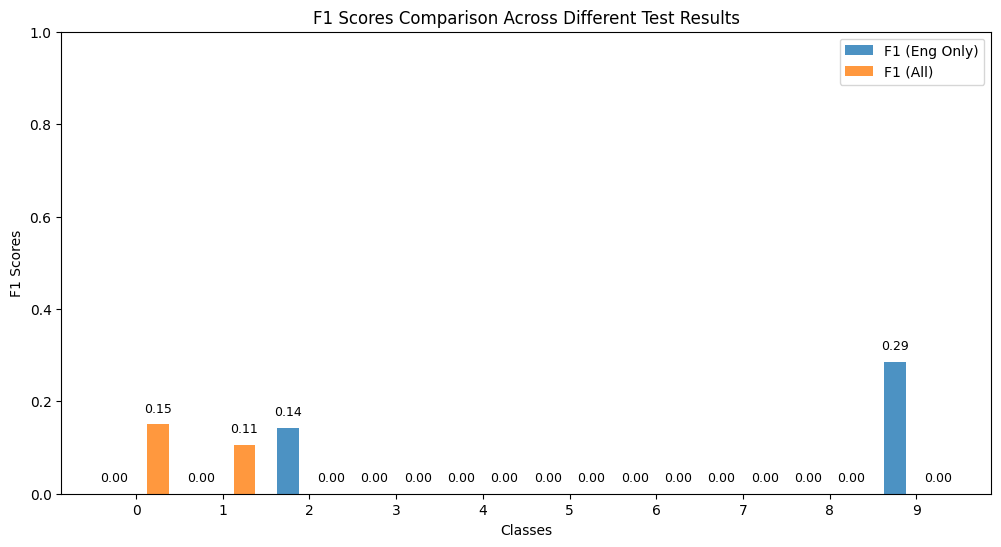

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Extract F1 scores from each test result
f1_scores_eng_only = test_results_eng_only.metrics["test_f1"]
#f1_scores_eng_all = test_results_eng_all.metrics["test_f1"]
f1_scores_all = test_results_all.metrics["test_f1"]

# Number of classes
num_classes = len(f1_scores_eng_only)

# Create x positions for the bars
x = np.arange(num_classes)
width = 0.25

# Plot the F1 scores
plt.figure(figsize=(12, 6))
bars_eng_only = plt.bar(x - width, f1_scores_eng_only, width, label='F1 (Eng Only)', alpha=0.8)
#bars_eng_all = plt.bar(x, f1_scores_eng_all, width, label='F1 (Eng + All)', alpha=0.8)
bars_all = plt.bar(x + width, f1_scores_all, width, label='F1 (All)', alpha=0.8)

# Add labels, title, and legend
plt.xlabel('Classes')
plt.ylabel('F1 Scores')
plt.title('F1 Scores Comparison Across Different Test Results')
plt.ylim(0, 1)
plt.xticks(ticks=x, labels=range(num_classes))
plt.legend()

# Add F1 score values on top of bars
for bars in [bars_eng_only, bars_all]:#bars_eng_all, bars_all]:
        for bar in bars:
                height = bar.get_height()
                plt.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 0.02,  # Slightly above the bar
        f'{height:.2f}',
                    ha='center',
                    va='bottom',
                    fontsize=9
        )

# Show the plot

plt.show()


In [48]:
# Convert F1 scores to plain Python floats and round to 3 decimals
f1_scores_eng_only = [round(float(score), 3) for score in f1_scores_eng_only]
#f1_scores_eng_all = [round(float(score), 3) for score in f1_scores_eng_all]
f1_scores_all = [round(float(score), 3) for score in f1_scores_all]

print("F1 Scores (Eng Only):", f1_scores_eng_only)
#print("F1 Scores (Eng + All):", f1_scores_eng_all)
print("F1 Scores (All):", f1_scores_all)


F1 Scores (Eng Only): [0.0, 0.0, 0.143, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.286]
F1 Scores (All): [0.15, 0.105, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [49]:
len(train_dataset_eng)

156

#### Inference

In [50]:
def inference(model, input_sentance, tokenizer, device):
    input_tokens = tokenizer(input_sentance, return_tensors='pt').to(device)
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        logits = model(**input_tokens)[0] # logits
    top_3_probs, top_3_indeces = torch.topk(logits, k=3, dim=1)
    top_3_experts = [f'expert_{i}' for i in top_3_indeces.squeeze().tolist()]
    return top_3_experts, top_3_probs.squeeze().tolist()
    

In [51]:
inference(model_all, "Déconnexion inattendue du système après une longue période d'inactivité sur l'application.", tokenizer_all, device)

(['expert_0', 'expert_1', 'expert_8'],
 [0.3005199432373047, 0.2992027699947357, 0.07683707773685455])

##### Manual check of patterns

In [53]:
# Group by 'ticket_description' and calculate class frequencies

sentence_class_dict = (
    pd.read_csv('data_all.csv', sep=';')
    .groupby('ticket_description')['expert_id']
    .value_counts()                         # Count occurrences of each class
    .groupby(level=0)                       # Regroup by 'ticket_description'
    .apply(lambda x: list(zip(x.index.get_level_values(1), x.values)))  # Create list of (class, frequency)
    .to_dict()
)

# Print the resulting dictionary
sentence_class_dict

{'Application fails to save settings.': [('expert_0', 3),
  ('expert_2', 1),
  ('expert_3', 1),
  ('expert_4', 1),
  ('expert_5', 1),
  ('expert_7', 1),
  ('expert_8', 1),
  ('expert_9', 1)],
 'Backup process fails intermittently.': [('expert_1', 3),
  ('expert_3', 2),
  ('expert_8', 2),
  ('expert_0', 1),
  ('expert_2', 1),
  ('expert_4', 1)],
 'Data not syncing with the cloud.': [('expert_2', 2),
  ('expert_8', 2),
  ('expert_0', 1),
  ('expert_5', 1),
  ('expert_6', 1),
  ('expert_7', 1)],
 "Des fuites de mémoire sont observées lors de l'exécution d'opérations intensives ou prolongées.": [('expert_3',
   4),
  ('expert_5', 2),
  ('expert_8', 2),
  ('expert_4', 1),
  ('expert_6', 1),
  ('expert_9', 1)],
 "Déconnexion inattendue du système après une longue période d'inactivité sur l'application.": [('expert_5',
   5),
  ('expert_2', 2),
  ('expert_1', 1),
  ('expert_6', 1),
  ('expert_7', 1)],
 'Email notifications not being sent.': [('expert_2', 2),
  ('expert_0', 1),
  ('expert_3', 